# Krusell-Smith Model

In [50]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc  # modules
from sequence_jacobian.hetblocks.hh_labor import solve_cn,cn

In [51]:
def household_init(a_grid, e_grid, r, w, eis):
    """
    Initialize the marginal value of assets (Va) for households.

    This function computes an initial guess for the marginal utility derivative of 
    the value function using a simple consumption guess. The cash-on-hand (coh) 
    is computed based on asset returns and labor income. Then, it assumes a proportional 
    consumption (10% of coh) to derive the marginal utility, adjusting for the interest rate.

    Parameters:
    a_grid : numpy.ndarray
        Asset grid (1-D array) representing different levels of assets.
    e_grid : numpy.ndarray
        Productivity grid (1-D array) representing different productivity levels.
    r : float
        The ex-post real interest rate.
    w : float
        The wage rate.
    eis : float
        Elasticity of intertemporal substitution.

    Returns:
    numpy.ndarray
        An array representing the initial marginal value of assets (Va) for each combination
        of productivity and asset level.
    """
    # Compute cash-on-hand (coh) as the sum of returns on assets and labor income.
    # np.newaxis is used to correctly broadcast the addition over all combinations of a_grid and e_grid.
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    
    # Set an initial consumption guess as 10% of cash-on-hand.
    # Compute the marginal utility based on this guess with CRRA utility.
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    
    return Va

@het(exogenous='Pi', policy='a', backward='Va', backward_init=household_init)
def household(Va_p, a_grid, e_grid, r, w, beta, eis):
    """
    Perform a single backward iteration for the household's dynamic programming problem 
    using the endogenous gridpoint method (EGM) with CRRA utility.

    This function computes the updated marginal value of assets (Va), optimal asset policy (a), 
    and consumption policy (c) for households today given the expected marginal utility of assets 
    next period (Va_p). The approach follows the EGM methodology as per Carroll (2006) and uses 
    the envelope condition under CRRA utility.

    Parameters
    ----------
    Va_p : numpy.ndarray
        (nE, nA) array of expected marginal utility of assets for the next period.
    a_grid : numpy.ndarray
        (nA,) asset grid representing different levels of assets.
    e_grid : numpy.ndarray
        (nE,) productivity grid representing different labor productivity levels.
    r : float
        Ex-post real interest rate.
    w : float
        Wage rate.
    beta : float
        Discount factor.
    eis : float
        Elasticity of intertemporal substitution. Note: The CRRA risk aversion coefficient is 1/eis.

    Returns
    -------
    Va : numpy.ndarray
        (nE, nA) updated marginal value of assets today.
    a : numpy.ndarray
        (nE, nA) asset policy (optimal asset choices) for households today.
    c : numpy.ndarray
        (nE, nA) consumption policy for households today.
    
    Notes
    -----
    The computation follows these steps:
      1. Adjust the expected marginal utility next period by the discount factor to obtain uc_nextgrid.
      2. Invert the marginal utility function to derive next period consumption (c_nextgrid).
      3. Compute cash-on-hand (coh) by adding the asset returns and labor income.
      4. Interpolate using the endogenous gridpoint method to obtain the asset policy 'a'.
      5. Ensure that the asset policy does not fall below the minimum asset level.
      6. Compute consumption (c) as the difference between cash-on-hand and the chosen asset.
      7. Update the current marginal value function (Va) via the envelope condition.
    """
    # Step 1: Compute the discounted expected marginal utility for next period.
    uc_nextgrid = beta * Va_p  # Multiply expected marginal utility by beta.

    # Step 2: Invert the marginal utility function to find next period consumption.
    # For CRRA utility, u'(c) = c^(-1/eis), hence c_nextgrid = (u')^(-eis).
    c_nextgrid = uc_nextgrid ** (-eis)

    # Step 3: Calculate cash-on-hand (coh).
    # Cash-on-hand is given by asset returns plus labor income.
    # a_grid is reshaped with np.newaxis to allow broadcasting with e_grid.
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]

    # Step 4: Compute the optimal asset policy using the EGM interpolation.
    # The interpolate_y method inverts the consumption function by mapping (consumption + assets)
    # onto the corresponding asset level in the cash-on-hand grid.
    a = interpolate.interpolate_y(c_nextgrid + a_grid[np.newaxis, :], coh, a_grid)

    # Step 5: Ensure the asset policy doesn't fall below the minimum asset value.
    misc.setmin(a, a_grid[0])

    # Step 6: Determine the consumption policy as the residual of cash-on-hand after choosing 'a'.
    c = coh - a

    # Step 7: Update the marginal value of assets (Va) today using the envelope condition.
    # Under CRRA utility, u'(c) = c^(-1/eis), so Va = (1 + r) * u'(c).
    Va = (1 + r) * c ** (-1 / eis)

    return Va, a, c

In [52]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    """
    Create the grids for the income process and assets for the household model.

    Parameters:
        rho_e (float): Persistence parameter for the income process.
        sd_e (float): Standard deviation of the income shock.
        nE (int): Number of discrete income states.
        amin (float): Minimum asset value.
        amax (float): Maximum asset value.
        nA (int): Number of asset grid points.

    Returns:
        tuple: A tuple containing:
            - e_grid: Grid representing income states.
            - Pi: Transition probability matrix for the income process.
            - a_grid: Discretized asset grid.
    """
    # Generate the income grid and transition matrix using the Rouwenhorst method.
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    
    # Generate the asset grid based on the provided minimum, maximum, and number of points.
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    
    return e_grid, Pi, a_grid


# Extend the household block by adding the make_grid function as a heterogeneous input.
household_ext = household.add_hetinputs([make_grid])

# Print the extended household block and its inputs for verification.
print(household_ext)
print(f'Inputs: {household_ext.inputs}')

<HetBlock 'household' with hetinput 'make_grid'>
Inputs: ['r', 'w', 'beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA']


In [53]:
@simple
def firm(K, L, Z, alpha, delta):
    """
    Compute factor returns and output using a Cobb-Douglas production function.

    Parameters:
        K: A callable or value representing capital. When called as K(-1), it returns the lagged capital value.
        L (float): Labor input.
        Z (float): Total factor productivity.
        alpha (float): Capital share parameter.
        delta (float): Depreciation rate of capital.

    Returns:
        tuple: A tuple (r, w, Y) where:
            r (float): Net interest rate (marginal product of capital minus depreciation).
            w (float): Wage rate (marginal product of labor).
            Y (float): Total output.
    """
    # Compute net interest rate: marginal product of capital minus depreciation.
    r = alpha * Z * (K(-1) / L) ** (alpha - 1) - delta

    # Compute wage rate: marginal product of labor.
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha

    # Compute total output using the Cobb-Douglas production function.
    Y = Z * (K(-1) ** alpha) * (L ** (1 - alpha))

    return r, w, Y


@simple
def mkt_clearing(K, A, Y, C, delta):
    """
    Evaluate market clearing conditions in the asset and goods markets.

    Parameters:
        K (float): Aggregate capital.
        A (float): Total assets in the economy.
        Y (float): Total output.
        C (float): Total consumption.
        delta (float): Depreciation rate of capital.

    Returns:
        tuple: A tuple (asset_mkt, goods_mkt) where:
            asset_mkt (float): Excess demand in the asset market (assets minus capital).
            goods_mkt (float): Excess demand in the goods market (output minus consumption and capital depreciation).
    """
    # Calculate asset market imbalance: total assets minus aggregate capital.
    asset_mkt = A - K

    # Calculate goods market imbalance: total output minus consumption and depreciation spending.
    goods_mkt = Y - C - delta * K

    return asset_mkt, goods_mkt

In [54]:
ks = create_model([household_ext, firm, mkt_clearing], name="Krusell-Smith")
print(ks.inputs)

['beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'K', 'L', 'Z', 'alpha', 'delta']


In [55]:
calibration = {'eis': 1, 'delta': 0.025, 'alpha': 0.11, 'rho_e': 0.966, 'sd_e': 0.5, 'L': 1.0,
               'nE': 3, 'nA': 100, 'amin': 0, 'amax': 200}
unknowns_ss = {'beta': 0.98, 'Z': 0.85, 'K': 3.}
targets_ss = {'r': 0.01, 'Y': 1., 'asset_mkt': 0.}

ss = ks.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='hybr')

print(ss)

<SteadyStateDict: ['eis', 'delta', 'alpha', 'rho_e', 'sd_e', 'L', 'nE', 'nA', 'amin', 'amax', 'beta', 'Z', 'K', 'r', 'w', 'Y', 'A', 'C', 'asset_mkt', 'goods_mkt'], internals=['household']>


In [56]:
T = 300
inputs = ['Z']
unknowns = ['K']
targets = ['asset_mkt']

G2 = ks.solve_jacobian(ss, unknowns, targets, inputs, T=T)

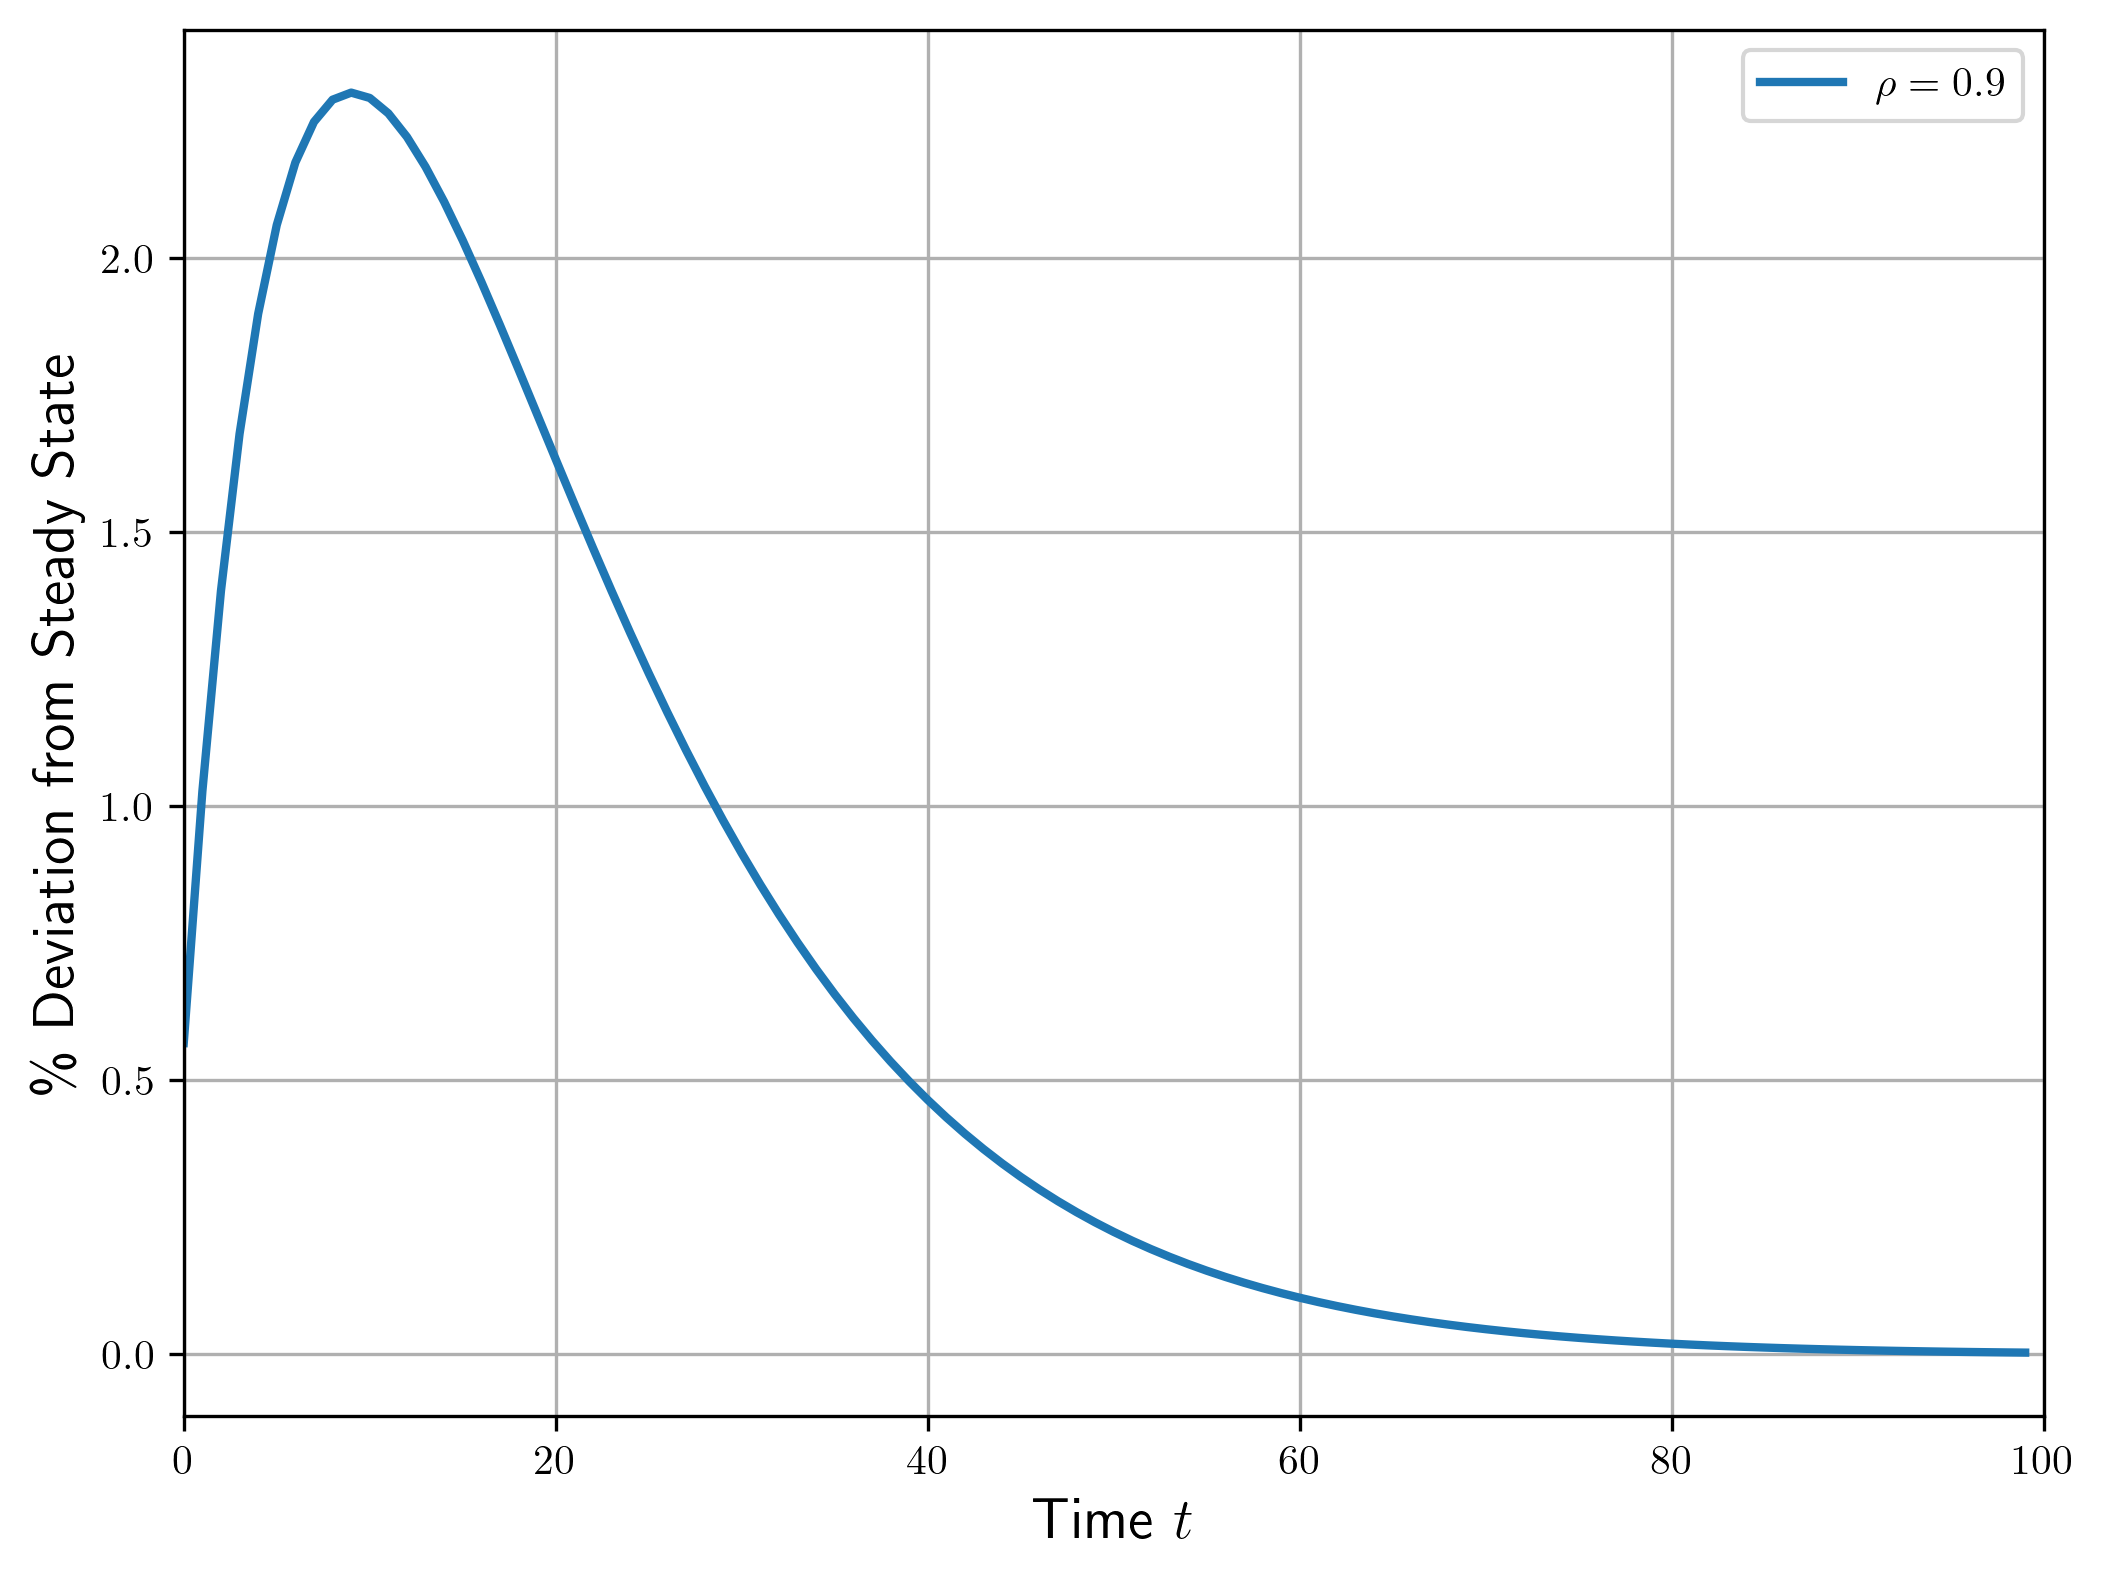

In [57]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True  # Enable LaTeX rendering for all text in plots

# Define an array of persistence parameters for the shocks to $Z$.
rhos = np.array([0.9,])

# Generate a matrix of shock paths ($dZ$) for each persistence parameter.
dZ = 0.01 * ss['Z'] * rhos ** (np.arange(T)[:, np.newaxis])
dK = G2['K']['Z'] @ dZ
# Create an enhanced plot with increased figure size, resolution, markers, grid, and a legend for better clarity.
plt.figure(figsize=(8, 6), dpi=300)
for i, rho in enumerate(rhos):
    plt.plot(100 *dK[:100, i], lw=2, markersize=4, label=f'$\\rho = {rho}$')
plt.xlim(0,100)
plt.ylabel(r'\% Deviation from Steady State', fontsize=14)
plt.xlabel(r'Time $t$', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# One-Asset HANK Model

In [58]:
def hh_init(a_grid, we, r, eis, T):
    fininc = (1 + r) * a_grid + T[:, np.newaxis] - a_grid[0]
    coh = (1 + r) * a_grid[np.newaxis, :] + we[:, np.newaxis] + T[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return fininc, Va

@het(exogenous='Pi', policy='a', backward='Va', backward_init=hh_init)
def hh(Va_p, a_grid, we, T, r, beta, eis, frisch, vphi):
    '''Single backward step via EGM.'''
    uc_nextgrid = beta * Va_p
    c_nextgrid, n_nextgrid = cn(uc_nextgrid, we[:, np.newaxis], eis, frisch, vphi)

    lhs = c_nextgrid - we[:, np.newaxis] * n_nextgrid + a_grid[np.newaxis, :] - T[:, np.newaxis]
    rhs = (1 + r) * a_grid
    c = interpolate.interpolate_y(lhs, rhs, c_nextgrid)
    n = interpolate.interpolate_y(lhs, rhs, n_nextgrid)

    a = rhs + we[:, np.newaxis] * n + T[:, np.newaxis] - c
    iconst = np.nonzero(a < a_grid[0])
    a[iconst] = a_grid[0]

    if iconst[0].size != 0 and iconst[1].size != 0:
        c[iconst], n[iconst] = solve_cn(we[iconst[0]],
                                        rhs[iconst[1]] + T[iconst[0]] - a_grid[0],
                                        eis, frisch, vphi, Va_p[iconst])

    Va = (1 + r) * c ** (-1 / eis)
    
    return Va, a, c, n

In [59]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    """
    Generate the income and asset grids.

    Uses the Rouwenhorst method to construct the Markov grid for income shocks 
    and creates an asset grid using the provided parameters.

    Parameters:
        rho_e (float): Persistence parameter for the income Markov process.
        sd_e (float): Standard deviation of the income shocks.
        nE (int): Number of states in the income grid.
        amin (float): Minimum asset level.
        amax (float): Maximum asset level.
        nA (int): Number of points in the asset grid.
    
    Returns:
        tuple: A tuple containing:
            - e_grid (array-like): The income/skill grid.
            - pi_e (array-like): Probabilities for the income grid states.
            - Pi (array-like): Transition probability matrix for the Markov process.
            - a_grid (array-like): The asset grid.
    """
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, pi_e, Pi, a_grid


def transfers(pi_e, Div, Tax, e_grid):
    """
    Calculate net transfers based on dividends and taxes with incidence rules.

    Dividends and taxes are allocated proportionally to skill as represented by 
    the income grid. The function scales these flows so that the aggregate values 
    match Div and Tax, respectively.

    Parameters:
        pi_e (array-like): Probability weights for each income state.
        Div (float): Total dividend value.
        Tax (float): Total tax value.
        e_grid (array-like): Income/skill grid used to determine the incidence.
    
    Returns:
        array-like: Net transfers for each income state (dividends minus taxes).
    """
    # Hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = e_grid, e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T


def wages(w, e_grid):
    """
    Compute skill-adjusted wages.

    Multiplies the base wage rate by the income/skill grid to yield wages 
    that vary with skill level.

    Parameters:
        w (float): Base wage rate.
        e_grid (array-like): Income/skill grid.
    
    Returns:
        array-like: The computed wages adjusted by skill.
    """
    we = w * e_grid
    return we

In [60]:
hh1 = hh.add_hetinputs([make_grid, transfers, wages])

In [61]:
def labor_supply(n, e_grid):
    """
    Compute effective labor supply adjusted for efficiency levels.

    This function calculates the effective labor supply by multiplying the labor input
    with a grid of efficiency (or skill) levels. The efficiency grid is reshaped to a
    column vector to allow broadcasting when performing the multiplication with n.

    Parameters:
        n (array-like): Labor supply input (scalar or vector).
        e_grid (array-like): One-dimensional array representing efficiency or skill levels.

    Returns:
        array-like: The effective labor supply computed as the product of n and the efficiency grid.
    """
    ne = e_grid[:, np.newaxis] * n
    return ne

In [62]:
hh_ext = hh1.add_hetoutputs([labor_supply])

In [63]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    """
    Calculate labor input and firm dividends.

    Parameters:
    Y (numeric): Total output produced by the firm.
    w (numeric): Wage rate.
    Z (numeric): Productivity factor.
    pi (object): Inflation factor, expected to support .apply(np.log) for logarithm computation.
    mu (numeric): Markup parameter.
    kappa (numeric): Adjustment cost parameter.

    Returns:
    tuple: A tuple (L, Div) where:
        L is the labor input computed as Y / Z,
        Div is the dividends computed as the residual after paying wages and inflation adjustment costs.
    """
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi):
    """
    Compute the nominal interest rate based on the monetary policy rule.

    Parameters:
    pi (callable): Current inflation factor; supports lag operator when called (e.g., pi(-1)).
    rstar (callable): Natural rate of interest; supports lag operator when called (e.g., rstar(-1)).
    phi (numeric): Coefficient that scales lagged inflation in the policy rule.

    Returns:
    numeric: The computed nominal interest rate.
    """
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r


@simple
def fiscal(r, B):
    """
    Calculate tax revenue from interest payments on bonds.

    Parameters:
    r (numeric): The interest rate.
    B (numeric): The stock of bonds.

    Returns:
    numeric: Tax revenue computed as the product of the interest rate and bond holdings.
    """
    Tax = r * B
    return Tax


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    """
    Determine the market clearing imbalances in the asset, labor, and goods markets.

    Parameters:
    A (numeric): Total asset supply.
    NE (numeric): Effective labor supply.
    C (numeric): Consumption.
    L (numeric): Labor demand.
    Y (numeric): Total output.
    B (numeric): Bond holdings.
    pi (object): Inflation factor; expected to support .apply(np.log) for logarithm computation.
    mu (numeric): Markup parameter.
    kappa (numeric): Adjustment cost parameter.

    Returns:
    tuple: A triple (asset_mkt, labor_mkt, goods_mkt) where:
        asset_mkt is the asset market imbalance (A - B),
        labor_mkt is the labor market imbalance (NE - L),
        goods_mkt is the goods market imbalance accounting for consumption and inflation adjustment costs.
    """
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    """
    Compute the residual for the New Keynesian Phillips Curve (NKPC).

    This function evaluates the NKPC residual given the current and forward-looking
    values of inflation, output, wages, and other economic parameters. The formula
    incorporates the adjustment for markups and the intertemporal tradeoffs implied 
    by forward-looking behavior.

    Parameters:
    -----------
    pi : callable
        Function or series representing the inflation rate. Supports time-forward 
        indexing using the call operator (e.g., pi(+1)).
    w : callable
        Function or series representing the wage rate.
    Z : callable
        Function or series representing the productivity shock.
    Y : callable
        Function or series representing the output.
    r : callable
        Function or series representing the interest rate.
    mu : float
        The markup parameter.
    kappa : float
        The sensitivity parameter affecting the response of inflation to wage variations.

    Returns:
    --------
    nkpc_res : numeric or array-like
        The computed residual of the NKPC equation.
    """
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1)) \
               - (1 + pi).apply(np.log)
    return nkpc_res


# Define the model blocks and create the HANK model using them.
blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

print(*hank.blocks, sep='\n')

<SimpleBlock 'monetary'>
<SimpleBlock 'nkpc'>
<SimpleBlock 'fiscal'>
<SimpleBlock 'firm'>
<HetBlock 'hh' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
<SimpleBlock 'mkt_clearing'>


In [64]:
calibration = {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 3,
               'amin': 0.0, 'amax': 150, 'nA': 100, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005,'B': 5.6,'phi': 1.5}

unknowns_ss = {'beta': 0.986,'vphi': 0.8,'w':0.833}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0,'nkpc_res':0}


ss = hank.solve_steady_state(calibration,unknowns_ss,targets_ss,solver="hybr")

In [65]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'Y', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'Tax', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Z']>


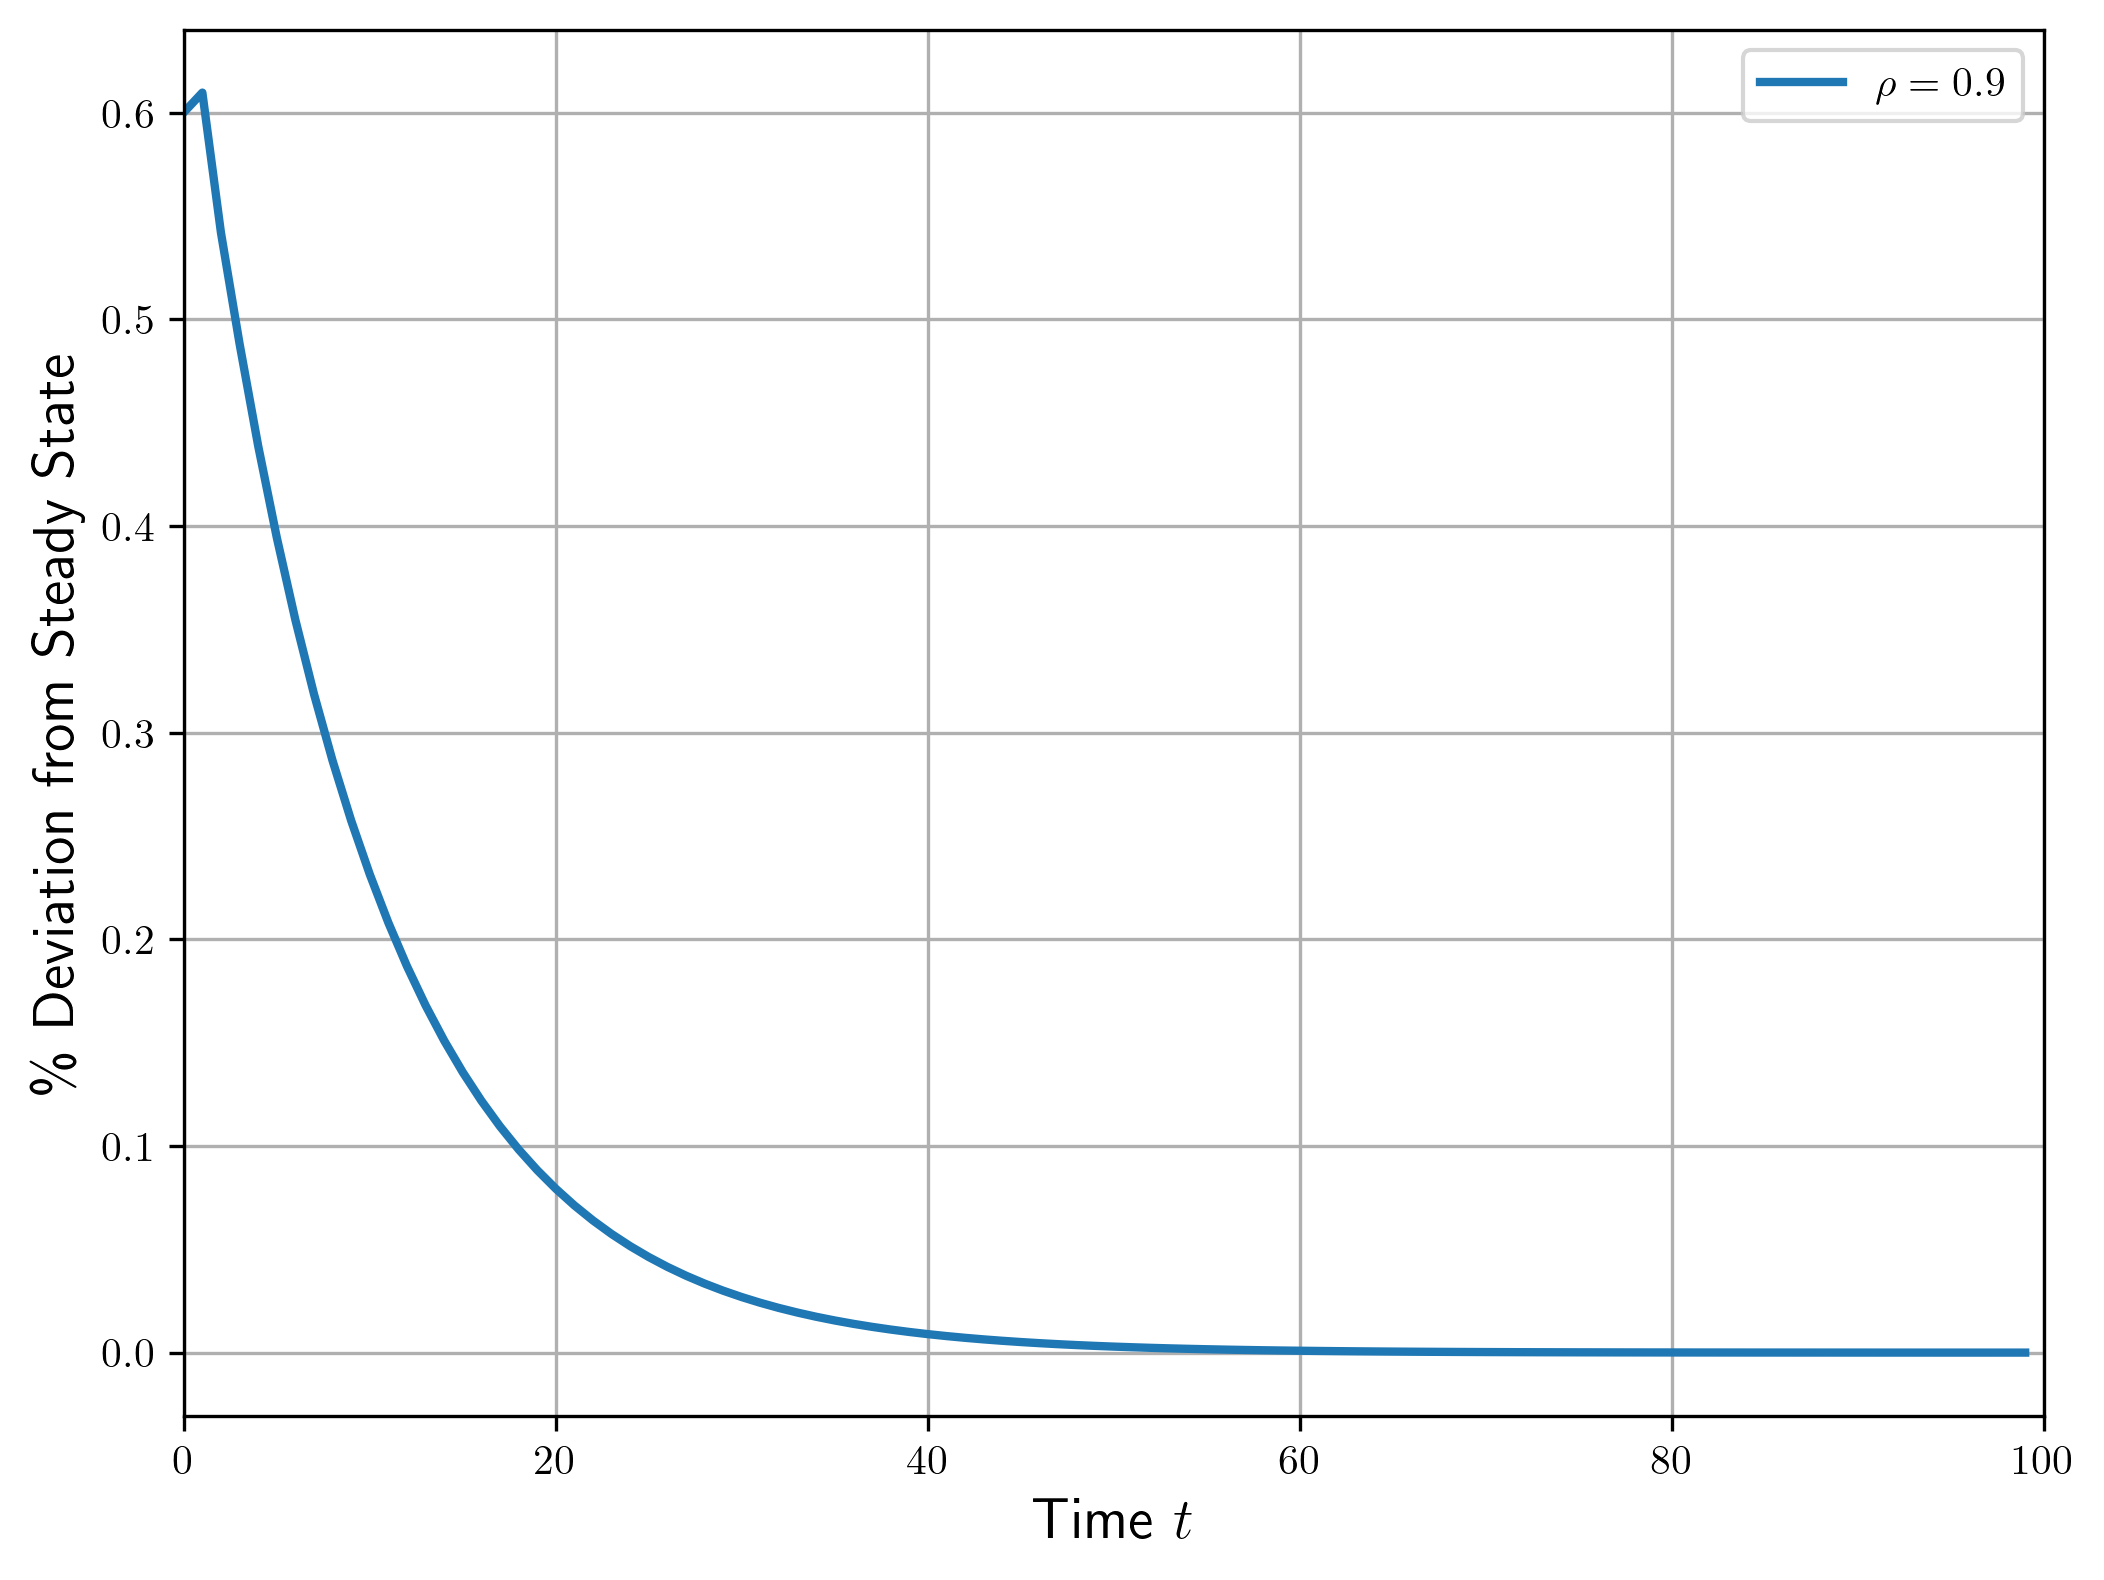

In [66]:
# Define an array of persistence parameters for the shocks to $Z$.
rhos = np.array([0.9,])

# Generate a matrix of shock paths ($dZ$) for each persistence parameter.
dZ = 0.01 * ss['Z'] * rhos ** (np.arange(T)[:, np.newaxis])
dY = G['Y']['Z'] @ dZ
# Create an enhanced plot with increased figure size, resolution, markers, grid, and a legend for better clarity.
plt.figure(figsize=(8, 6), dpi=300)
for i, rho in enumerate(rhos):
    plt.plot(100 *dY[:100, i], lw=2, markersize=4, label=f'$\\rho = {rho}$')
plt.xlim(0,100)
plt.ylabel(r'\% Deviation from Steady State', fontsize=14)
plt.xlabel(r'Time $t$', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## Consistency Check

In [67]:
@simple
def nkpc_ss(Z, mu):
    """
    Compute the steady-state wage as derived from the New Keynesian Phillips Curve.

    Parameters:
    Z (numeric): Productivity factor.
    mu (numeric): Markup parameter.

    Returns:
    numeric: The steady-state wage computed as Z divided by mu.
    """
    w = Z / mu
    return w

In [68]:
blocks_ss = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc_ss]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")


In [69]:
calibration = {'eis': 0.5, 'frisch': 0.5, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 3,
               'amin': 0.0, 'amax': 150, 'nA': 100, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5,'B': 5.6,}

unknowns_ss = {'beta': 0.986,'vphi': 0.8,}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

In [70]:
for k in ss0.keys():
    if not np.all(np.isclose(ss[k], ss0[k])):
        print(f"Mismatch found for {k}:")
        print(f"ss[{k}] = {ss[k]}")
        print(f"ss0[{k}] = {ss0[k]}")

There's no output, therefore the 2 models are consistent, which proves that my alternative calibration is correct.